In [1]:
import janestreet
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import torch as pt
from tqdm.notebook import tqdm, trange
from scipy import stats
import torch as pt

In [2]:
import princo_ml as pml
from princo_ml.controllers.Controller import Controller as Control
from princo_ml.clusters import DataCluster as Data, LearnCluster as Learn
from princo_ml.utils.learn_modules.learners import GradientLearner, NewtonLearner, MomentumLearner, SmoothLearner
from princo_ml.utils.learn_modules.activators import LinearActivator, SigmoidActivator, TanhActivator, ReluActivator
from princo_ml.utils.losses.CrossEntLoss import CrossEntLoss

In [3]:
pt.set_default_tensor_type(pt.cuda.FloatTensor)
#pt.set_default_tensor_type(pt.FloatTensor)

In [4]:
def grad_calc(loss, coefs):
    coef_list = pd.Series(coefs)
    gradients = pd.Series(
        pt.autograd.grad(loss, coef_list.values),
        index = coef_list.index,
    ).to_dict()
    return gradients

In [5]:
paths = {
    'features': Path('./data/features.csv'),
    'train': Path('./data/train.csv'),
    'test': Path('./data/example_test.csv'),
}

In [6]:
raw_data = pd.read_csv(paths['train']).set_index('ts_id')
raw_data.insert(
    raw_data.columns.get_loc('resp')+1,
    'resp_pos',
    raw_data['resp'] > 0,
)

In [7]:
train_ratio = 0.6
train_idx = np.concatenate([
    np.random.choice(data.index, size=int(len(data) * train_ratio), replace=False)
    for _, data in raw_data.groupby('date')
])
valid_idx = raw_data.index[~raw_data.index.isin(train_idx)].values

In [8]:
raw_features = [col for col in raw_data.columns if col.startswith('feature')]

dataset = raw_data.loc[raw_data['date'] == 0].copy()
dataset = dataset.join(pd.isnull(dataset[raw_features]), rsuffix='_null').fillna(0)
dataset = dataset.join(
    dataset[raw_features] == dataset[raw_features].apply(lambda x: x.min()),
    rsuffix='_min',
).astype(float)

feature_cols = [col for col in dataset.columns if col.startswith('feature')]
target_cols = ['resp_pos']

In [9]:
dataset_next = raw_data.loc[raw_data['date'] == 1].copy()
dataset_next = dataset_next.join(pd.isnull(dataset_next[raw_features]), rsuffix='_null').fillna(0)
dataset_next = dataset_next.join(
    dataset_next[raw_features] == dataset_next[raw_features].apply(lambda x: x.min()),
    rsuffix='_min',
).astype(float)

In [10]:
learner = SmoothLearner
learn_rate_kwargs = {'seed_learn': 1e-0}

loss = CrossEntLoss
loss_kwargs = {'mean': True}

batcher_kwargs = {'proportion': 1.0}

control = Control('regression_controller')

control.add_cluster(
    Data(
        'data_cluster',
        dataset[feature_cols + target_cols],
        batcher_kwargs=batcher_kwargs,
        loss=loss, loss_kwargs=loss_kwargs,
    )
)
control.link_add(Learn(
    'learn_cluster_1',
    module_kwargs=dict(
        nodes=32,
        activator=TanhActivator,
        learner=learner,
        learn_rate_kwargs=learn_rate_kwargs,
    )),
    'data_cluster', 'input', data_cols=feature_cols,
)
control.link_add(
    Learn(
        'learn_cluster_out',
        module_kwargs=dict(
            nodes=len(target_cols),
            activator=SigmoidActivator,
            learner=learner,
            learn_rate_kwargs=learn_rate_kwargs,
        ),
    ),
    #'data_cluster', 'input', data_cols=feature_cols,
    'learn_cluster_1', 'input',
)

control.link_clusters('learn_cluster_out', 'data_cluster', data_cols=target_cols)

control.enable_network()
control.train_model(1000)

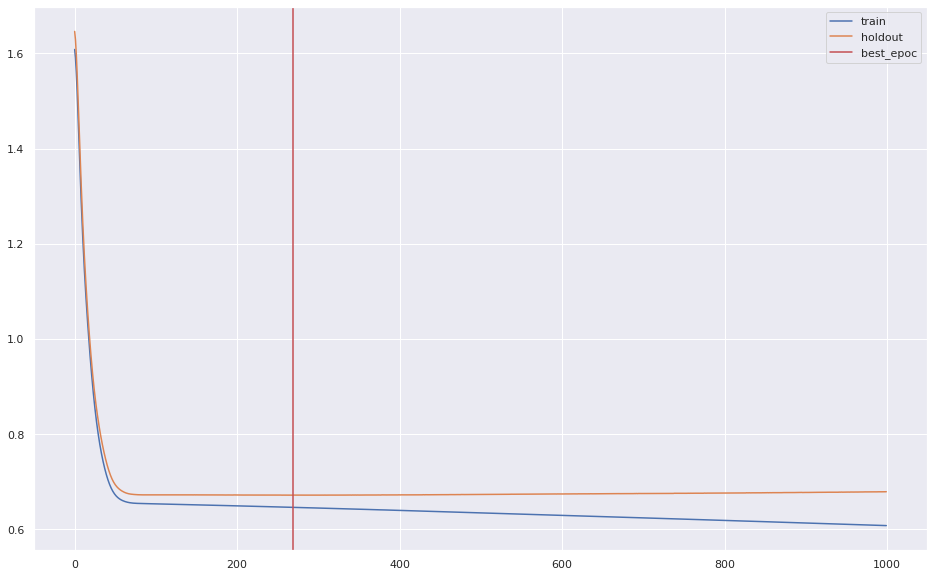

In [11]:
control.plot_losses()

In [12]:
predict = control.predict({'data_cluster': dataset_next[feature_cols + target_cols]})

In [13]:
final_data = pd.DataFrame(np.concatenate([
    predict['outputs']['learn_cluster_out'],
    (dataset_next[target_cols] == 1).values,
], axis=1), columns=['predict', 'actual'], index=dataset_next.index)

<AxesSubplot:xlabel='predict', ylabel='Density'>

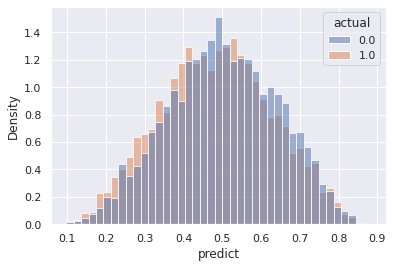

In [14]:
sns.histplot(data=final_data, x='predict', hue='actual', stat='density')

In [15]:
samples = [
    dataset_next.loc[
        final_data.index[final_data['predict'] > np.random.uniform(size=len(final_data))],
        ['weight', 'resp'],
    ].prod(axis=1).sum()
    for _ in trange(10000)
]

<AxesSubplot:ylabel='Count'>

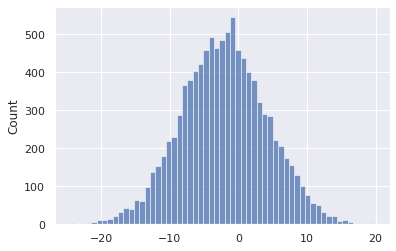

In [16]:
sns.histplot(samples)